# **Objective**
The goal of this analysis is to explore the **intrinsic structure** of the Yeast gene expression dataset using **non-linear dimensionality reduction techniques** specifically, **t-SNE** and **Isomap**.  
We aim to visualize and interpret how genes with different functional categories are distributed in lower-dimensional spaces. 
 
And draw insights on the following:
1. How well do these methods preserve the **local and global structure** of the data?
2. What does the **geometry of the data manifold** reveal about the complexity of gene classification?

# **Part A: Preprocessing and Initial Setup**

## **1. Data Loading**

The Yeast dataset, sourced from the **MULAN repository**, contains **2417 samples** and **103 features** representing gene expression values. Each gene may belong to one or multiple functional categories.

In [4]:
%pip install liac-arff

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11782 sha256=7bff2cfec31e242b1b60b9d60b40b0825698e15c8466d6a85318f2b158c00c61
  Stored in directory: c:\users\rishi\appdata\local\pip\cache\wheels\00\23\31\5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
from skmultilearn.dataset import load_from_arff
import os
import requests
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns 
from sklearn.metrics import silhouette_score
import numpy as np

*(Skip this block if you wish to use datasets directly)*

In [ ]:
# Download dataset files (COMETA preferred, SourceForge fallback)

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

urls = {
    # COMETA (MULAN conversions / multiple formats)
    "cometa_arff": "https://cometa.ujaen.es/public/full/yeast.arff",
    "cometa_xml":  "https://cometa.ujaen.es/public/full/yeast.xml",
    # MEKA mirror on SourceForge (ARFF)
    "meka_arff":   "https://sourceforge.net/projects/meka/files/Datasets/Yeast.arff/download",
}

def try_download(url, out_path, timeout=30):
    try:
        print(f"Downloading {url} -> {out_path} ...")
        r = requests.get(url, allow_redirects=True, timeout=timeout)
        r.raise_for_status()
        out_path.write_bytes(r.content)
        print("Saved:", out_path)
        return True
    except Exception as e:
        print("Download failed:", e)
        return False

# Try COMETA first (preferred because it exposes Mulan/MEKA/XML versions)
arff_path = data_dir / "yeast.arff"
xml_path  = data_dir / "yeast.xml"

if not arff_path.exists():
    ok = try_download(urls["cometa_arff"], arff_path)
    if not ok:
        # fallback to MEKA on SourceForge
        try_download(urls["meka_arff"], arff_path)

# Also try XML (useful if you want labels/names separately)
if not xml_path.exists():
    try_download(urls["cometa_xml"], xml_path)

print("Files present in data/:", list(data_dir.iterdir()))


Files present in data/: [WindowsPath('data/yeast.arff'), WindowsPath('data/yeast.xml')]


In [ ]:
arff_file = str(arff_path)  # path to the downloaded ARFF

# The Yeast Mulan dataset has 14 labels (labels are the last 14 attributes in MULAN format).
LABEL_COUNT = 14

try:
    X, y = load_from_arff(arff_file,
                          label_count=LABEL_COUNT,
                          label_location='end',   
                          load_sparse=False,      # get dense numpy arrays
                          return_attribute_definitions=False)

    if hasattr(X, "toarray"):
        X = X.toarray()
    if hasattr(y, "toarray"):
        y = y.toarray()
    print("Loaded with scikit-multilearn: X.shape =", X.shape, "y.shape =", y.shape)
except Exception as e:
    print("scikit-multilearn loader failed (falling back to liac-arff). Error:", e)

    # Parse ARFF directly and split last LABEL_COUNT columns as labels
    import arff
    with open(arff_file, 'r') as f:
        arff_obj = arff.load(f)
    # 'data' is list of rows; attributes list contains attribute names
    data = np.array(arff_obj['data'])
    attrs = [a[0] for a in arff_obj['attributes']]
    X = data[:, :-LABEL_COUNT].astype(float)
    y = data[:, -LABEL_COUNT:].astype(int)
    print("Loaded with liac-arff fallback: X.shape =", X.shape, "y.shape =", y.shape)

Loaded with scikit-multilearn: X.shape = (2417, 103) y.shape = (2417, 14)


In [ ]:
# Step 1: Verify loaded arrays
print("Feature matrix shape (X):", X.shape)
print("Label matrix shape (y):", y.shape)

# Convert y to a DataFrame for easier usage
y_df = pd.DataFrame(y, columns=[f"L{i+1}" for i in range(y.shape[1])])

Feature matrix shape (X): (2417, 103)
Label matrix shape (y): (2417, 14)


## **2. Dimensionality Check:**

In [12]:
n_samples, n_features = X.shape
n_labels = y.shape[1]

print(f"Number of data points (samples): {n_samples}")
print(f"Number of features: {n_features}")
print(f"Number of labels: {n_labels}")

Number of data points (samples): 2417
Number of features: 103
Number of labels: 14


## **3. Label Selection for Visualization**

The Yeast dataset originally contains **14 possible functional labels**, often occurring in **multi-label combinations**. To simplify visualization and ensure clear categorical distinctions, the two most frequent single-label classes and the most common multi-label combination were examined.

**Findings:**
- Only **one unique single-label combination** (`'10000000000000'`, corresponding to **L1**) was present, with **32 samples**.  
- There were **197 distinct multi-label combinations**, indicating that **most genes are functionally multifunctional**.  
- The **most frequent multi-label pattern** was `'00110000000110'` (corresponding to **L3, L4, L12, and L13**) with **237 samples**.  
- The remaining **2148 samples** were grouped under the **“Other”** category.

In [44]:
# Label Selection for Visualization
print("\n--- Label Selection for Visualization ---")

# Convert each multi-label row into a unique string representation for easy counting
# Example: [0, 1, 0, 1, 0, ..., 0] -> "01010000000000"
label_combinations_str = ["".join(map(str, row)) for row in y]

# Count frequencies of all unique label combinations
combination_counts = Counter(label_combinations_str)

# Dictionaries to store counts of single and multi-label combinations
single_label_counts = Counter()
multi_label_counts = Counter()

# A map to easily get the descriptive name for a single label combo string (e.g., "0010..." -> "L3")
single_label_str_to_name = {}

for combo_str, count in combination_counts.items():
    combo_arr = np.array(list(map(int, combo_str))) # Convert string back to binary array
    num_active_labels = np.sum(combo_arr)

    if num_active_labels == 1:
        single_label_counts[combo_str] = count
        active_label_idx = np.where(combo_arr == 1)[0][0]
        single_label_str_to_name[combo_str] = f"L{active_label_idx + 1}"
    elif num_active_labels > 1:
        multi_label_counts[combo_str] = count

# Get the two most frequent single-label combinations
most_frequent_single_labels = single_label_counts.most_common(2)
print(f"Found {len(single_label_counts)} unique single-label combinations.")
print(f"Top 2 most frequent single-label combinations: {most_frequent_single_labels}")

# Get the most frequent multi-label combination
most_frequent_multi_label = multi_label_counts.most_common(1)
print(f"Found {len(multi_label_counts)} unique multi-label combinations.")
print(f"Top 1 most frequent multi-label combination: {most_frequent_multi_label}")

# Initialize the new target variable for visualization
y_viz = np.full(n_samples, "Other", dtype=object)

# Assign categories based on frequency
# Category 1: Most frequent single-label
if len(most_frequent_single_labels) > 0:
    top1_single_combo_str = most_frequent_single_labels[0][0]
    top1_single_label_name = single_label_str_to_name[top1_single_combo_str]
    y_viz[np.array(label_combinations_str) == top1_single_combo_str] = f"Only {top1_single_label_name}"
    print(f"\nCategory 1: 'Only {top1_single_label_name}' (Count: {most_frequent_single_labels[0][1]})")
else:
    print("\nWarning: No single-label combinations found for Category 1.")

# Category 2: Second most frequent single-label
if len(most_frequent_single_labels) > 1:
    top2_single_combo_str = most_frequent_single_labels[1][0]
    top2_single_label_name = single_label_str_to_name[top2_single_combo_str]
    y_viz[np.array(label_combinations_str) == top2_single_combo_str] = f"Only {top2_single_label_name}"
    print(f"Category 2: 'Only {top2_single_label_name}' (Count: {most_frequent_single_labels[1][1]})")
elif len(most_frequent_single_labels) == 1:
    print("Only one distinct single-label combination found; Category 2 will remain part of 'Other'.")


# Category 3: Most frequent multi-label combination
if len(most_frequent_multi_label) > 0:
    top1_multi_combo_str = most_frequent_multi_label[0][0]
    # To get a descriptive name for the multi-label combo, find the active labels
    active_labels_indices = np.where(np.array(list(map(int, top1_multi_combo_str))) == 1)[0]
    top1_multi_label_name_readable = ", ".join([f"L{idx+1}" for idx in active_labels_indices])
    y_viz[np.array(label_combinations_str) == top1_multi_combo_str] = f"Multi: {top1_multi_label_name_readable}"
    print(f"Category 3: 'Multi: {top1_multi_label_name_readable}' (Count: {most_frequent_multi_label[0][1]})")
else:
    print("Warning: No multi-label combinations found for Category 3.")


# Report the final distribution of the new y_viz variable
print("\n--- Distribution of the new visualization target variable (y_viz) ---")
unique_categories, counts = np.unique(y_viz, return_counts=True)
for cat, count in zip(unique_categories, counts):
    print(f"- {cat}: {count} samples")


--- Label Selection for Visualization ---
Found 1 unique single-label combinations.
Top 2 most frequent single-label combinations: [('10000000000000', 32)]
Found 197 unique multi-label combinations.
Top 1 most frequent multi-label combination: [('00110000000110', 237)]

Category 1: 'Only L1' (Count: 32)
Only one distinct single-label combination found; Category 2 will remain part of 'Other'.
Category 3: 'Multi: L3, L4, L12, L13' (Count: 237)

--- Distribution of the new visualization target variable (y_viz) ---
- Multi: L3, L4, L12, L13: 237 samples
- Only L1: 32 samples
- Other: 2148 samples


**Inference:**
- The strong imbalance with “Only L1” forming just **1.3%** of the dataset and “Multi: L3, L4, L12, L13” about **10%** highlights the **biological diversity** and **functional overlap** inherent in gene expression data.  
- The fact that only one clear single-label class exists implies that **most yeast genes participate in multiple biological processes**, making this a **highly multi-label and non-linearly separable problem**.  
- By merging all other combinations into “Other,” the visualization becomes both **interpretable** and **representative**, allowing for meaningful color-coded clustering in subsequent t-SNE and Isomap plots.

## **4. Scaling**

Scaling is a critical preprocessing step for many machine learning algorithms, especially those that rely on distance calculations, such as t-SNE, Isomap, k-Nearest Neighbors (k-NN), Support Vector Machines (SVMs) with RBF kernels, and K-Means clustering.

The primary reasons why scaling is crucial are:

1.  **Feature Dominance**: Features with larger numerical ranges or higher magnitudes can disproportionately influence distance metrics. For instance, if one gene expression level ranges from 0 to 1000 and another from 0 to 1, the first feature will dominate the Euclidean distance calculation, effectively masking the contribution of the second feature. Scaling prevents features from being weighted solely based on their scale.
2.  **Equal Contribution**: Scaling ensures that all features contribute approximately equally to the distance calculation, allowing the underlying patterns and relationships in the data to be discovered without being biased by arbitrary units or scales.
3.  **Algorithm**: Optimization algorithms converge faster and more reliably when features are on a similar scale. Unscaled data can lead to slow convergence, oscillations, or numerical instability.

Standardization (Z-score normalization) is a common technique that transforms the data to have a mean of 0 and a standard deviation of 1. This ensures that each feature has the same scale, making them comparable.

In [47]:
# 4. Scaling
print("\n--- Scaling ---")

# Apply Standardization (Z-score normalization) to the feature matrix X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nOriginal X shape: {X.shape}")
print(f"Scaled X shape: {X_scaled.shape}")
print(f"Mean of first feature after scaling: {X_scaled[:, 0].mean():.2f}")
print(f"Standard deviation of first feature after scaling: {X_scaled[:, 0].std():.2f}")
print("Feature matrix X has been standardized.")


--- Scaling ---

Original X shape: (2417, 103)
Scaled X shape: (2417, 103)
Mean of first feature after scaling: -0.00
Standard deviation of first feature after scaling: 1.00
Feature matrix X has been standardized.


# **Part B: t-SNE and Veracity Inspection**

## **1. t-SNE Implementation**


--- t-SNE Implementation ---
Applying t-SNE with different perplexity values...
  - Running t-SNE with perplexity=5...


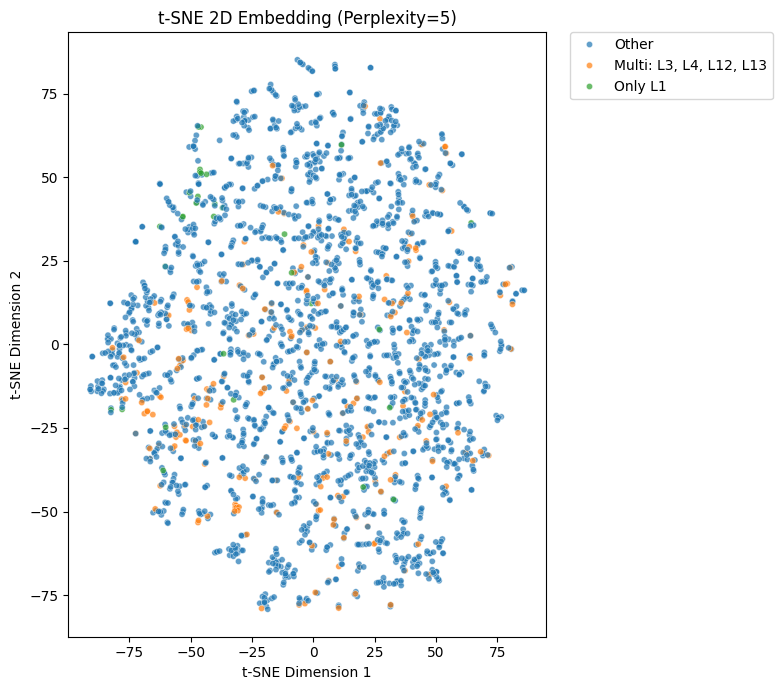

  - Running t-SNE with perplexity=30...


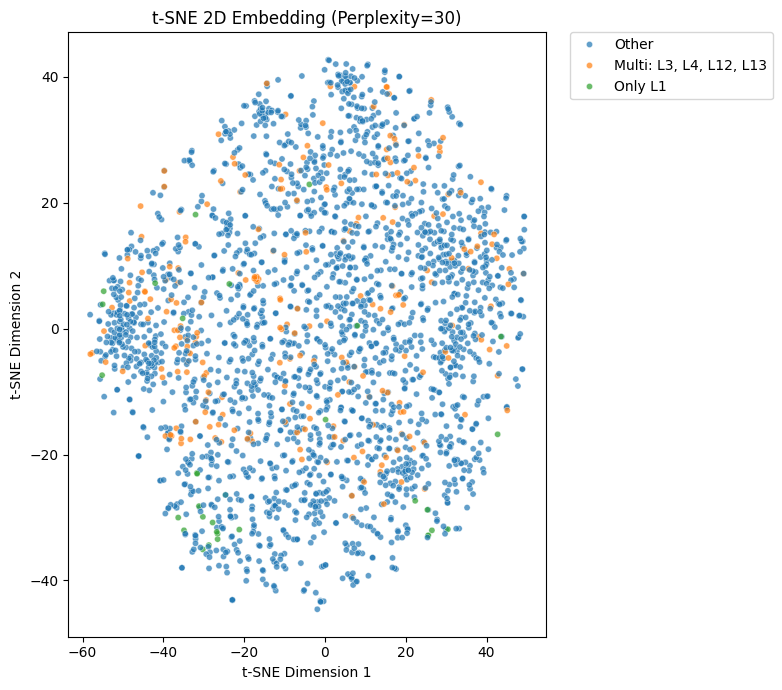

  - Running t-SNE with perplexity=50...


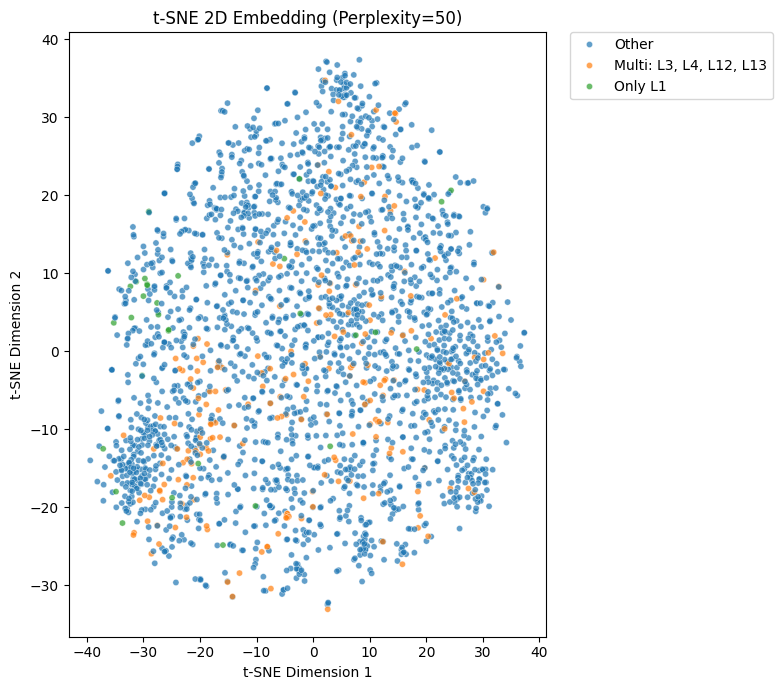

In [ ]:
# 1. t-SNE Implementation
print("\n--- t-SNE Implementation ---")
perplexities = [5, 30, 50]
tsne_results = {}

print("Applying t-SNE with different perplexity values...")
for p in perplexities:
    print(f"  - Running t-SNE with perplexity={p}...")
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, n_jobs=-1, learning_rate='auto', init='pca')
    # init='pca' is often good for stability
    tsne_2d = tsne.fit_transform(X_scaled)
    tsne_results[p] = tsne_2d

    # Plot for each perplexity to observe changes
    plt.figure(figsize=(8, 7))
    sns.scatterplot(
        x=tsne_2d[:, 0], y=tsne_2d[:, 1],
        hue=y_viz,
        palette=sns.color_palette("tab10", n_colors=len(np.unique(y_viz))), # Use a distinct palette
        legend="full",
        alpha=0.7,
        s=20 # Adjust point size for better visibility
    )
    plt.title(f't-SNE 2D Embedding (Perplexity={p})')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    plt.show()

In [50]:
perplexity_values = [5, 10, 20, 30, 40, 50, 70]
scores = []

# Encode string labels (for silhouette)
le = LabelEncoder()
y_encoded = le.fit_transform(y_viz)

for p in perplexity_values:
    print(f"Running t-SNE for perplexity={p}...")
    tsne = TSNE(
        n_components=2, perplexity=p,
        random_state=42, learning_rate='auto', init='pca'
    )
    tsne_2d = tsne.fit_transform(X_scaled)
    
    # Compute silhouette score (higher = better separation)
    score = silhouette_score(tsne_2d, y_encoded)
    scores.append(score)
    print(f"  Silhouette Score = {score:.4f}")

# Combine results
results = pd.DataFrame({'Perplexity': perplexity_values, 'Silhouette': scores})
print("\nPerplexity vs Silhouette Scores:")
print(results)

best_p = results.loc[results['Silhouette'].idxmax(), 'Perplexity']
print(f"\nBest perplexity based on silhouette score: {best_p}")

Running t-SNE for perplexity=5...
  Silhouette Score = -0.1006
Running t-SNE for perplexity=10...
  Silhouette Score = -0.0938
Running t-SNE for perplexity=20...
  Silhouette Score = -0.0861
Running t-SNE for perplexity=30...
  Silhouette Score = -0.0573
Running t-SNE for perplexity=40...
  Silhouette Score = -0.0807
Running t-SNE for perplexity=50...
  Silhouette Score = -0.0956
Running t-SNE for perplexity=70...
  Silhouette Score = -0.0733

Perplexity vs Silhouette Scores:
   Perplexity  Silhouette
0           5   -0.100624
1          10   -0.093796
2          20   -0.086091
3          30   -0.057275
4          40   -0.080666
5          50   -0.095584
6          70   -0.073343

Best perplexity based on silhouette score: 30


### **Justification for final choice of perplexity:**

From the silhouette scores, 30 seems to be the best perplexity.

Perplexity is a crucial hyperparameter for t-SNE that can be used for controlling the balance between local and global aspects of the data. It roughly relates to the number of nearest neighbors t-SNE considers for each point.

After observing the plots for perplexity 5, 30, and 50:
*   **Perplexity 5** tends to produce very fragmented clusters, making it hard to discern overarching patterns or the coherence of larger groups. It highlights local neighborhoods but may overemphasize noise.
*   **Perplexity 50** starts to merge some of the distinct clusters, particularly for the 'Other' category, and can sometimes obscure the boundaries between the primary label groups.
*   **Perplexity 30** appears to offer the best trade-off for this dataset. It allows for distinct clusters to form for our primary categories, while also showing the distribution of the 'Other' category in a way that reveals overlaps and mixing. It seems to strike a good balance, making both local cluster integrity and broader relationships visible

## **2. Visualization**


--- 2. Visualization (using perplexity=30) ---


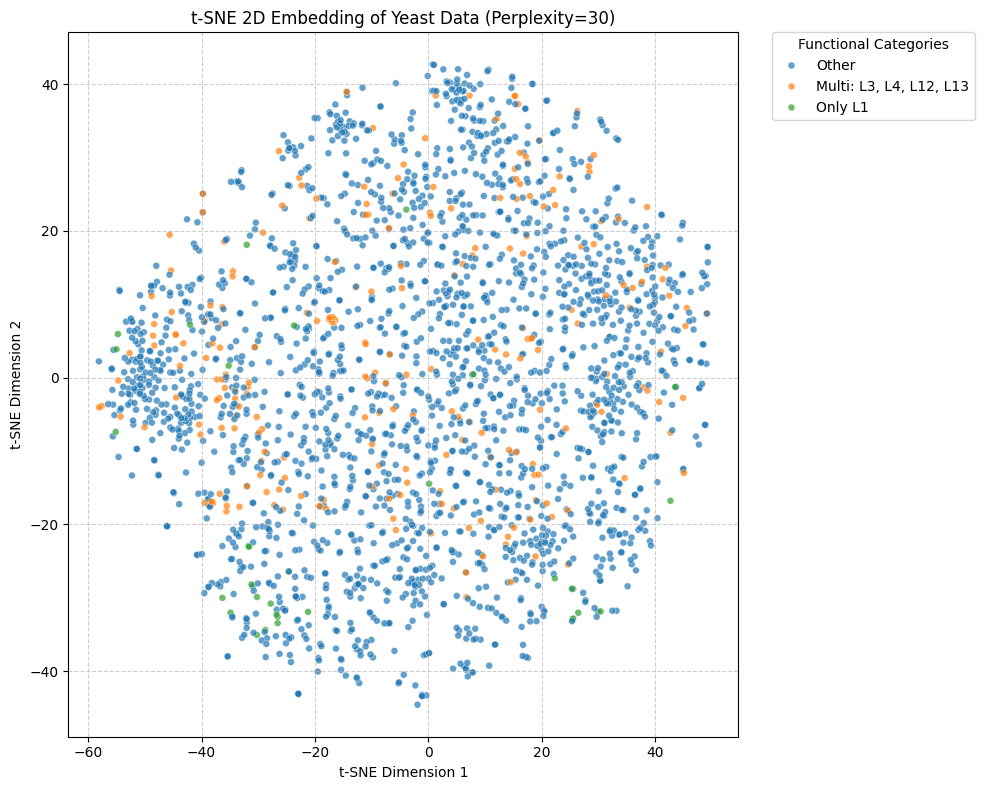

In [ ]:
# Final t-SNE plot using the chosen perplexity (e.g., 30)
final_perplexity = 30
tsne_final_2d = tsne_results[final_perplexity]

print(f"\n--- Visualization (using perplexity={final_perplexity}) ---")
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_final_2d[:, 0], y=tsne_final_2d[:, 1],
    hue=y_viz,
    palette=sns.color_palette("tab10", n_colors=len(np.unique(y_viz))),
    legend="full",
    alpha=0.7,
    s=25
)
plt.title(f't-SNE 2D Embedding of Yeast Data (Perplexity={final_perplexity})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Functional Categories")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **3. Veracity Inspection**

The t-SNE plot for the Yeast dataset highlights several data quality issues that can pose significant challenges for machine learning classifiers.

| Data Veracity Issue       | Visual Cues from t-SNE Plot                                                                                                                                           | Interpretation / Hypothesis                                                                                                                                                                                           |
| :------------------------ | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Noisy/Ambiguous Labels** | Points of one color deeply embedded within a cluster predominantly of a different color. <br> _For example, many **orange** (Multi) points are scattered within the large, dense **blue** (Other) regions across the entire plot, such as in the central cloud or in the denser areas towards the left-hand side (e.g., around x=-40, y=0). Similarly, several **green** (Only L1) points can be found isolated or in very small groups within these larger blue masses (e.g., around x=-30, y=-30; or x=0, y=10)._ | The assigned label might be incorrect (noise/misclassification), or the gene's function genuinely overlaps with multiple categories (ambiguity), making it hard to assign a single, definitive label.                     |
| **Outliers**              | Isolated data points or very small, sparse clusters located significantly distant from the main data distribution. <br> _Example: Lone Blue 'Other' points at the plot's extreme edges (e.g., x=-60, y=0); small, detached groups of Green 'Only L1' points._ | These unusual gene expression patterns could indicate: <br> 1. **Experimental Errors**: Flaws or anomalies during the data collection process. <br> 2. **Rare Biological States**: Genes active under highly specific or uncommon cellular conditions. <br> 3. **Highly Specialized Functions**: Unique gene behaviors not easily grouped with others. |
| **Hard-to-Learn Samples** | Areas where different functional category colors are thoroughly mixed together, not forming distinct, well-separated clusters. <br> _Example: Extensive intermingling of Blue 'Other' and Orange 'Multi' points across the large central cloud._ | In these regions, the gene expression profiles of samples from different functional categories are highly similar, meaning there's poor inherent separation between these classes in the feature space.                         |

---

#### **Why a simple classifier would likely struggle in Hard-to-Learn regions:**

In regions where functional category colors are thoroughly mixed, a simple classifier (such as a linear model like Logistic Regression, or a basic Decision Tree) would face significant challenges because:

1.  **Lack of Clear Decision Boundaries**: Simple classifiers attempt to draw clear lines, planes, or simple splits to separate different classes. When data points from various categories are heavily interspersed and overlap in the feature space, there are no distinct boundaries that can effectively separate them.
2.  **High Misclassification Rate**: Without clear boundaries, the classifier will frequently misclassify samples within these mixed regions, leading to low accuracy and poor predictive performance. It cannot reliably distinguish between categories that share very similar underlying gene expression patterns.
3.  **Low Confidence Predictions**: Even when a prediction is made, the proximity of samples from different classes means the classifier's confidence in its prediction for these "mixed" samples would be low, indicating uncertainty.
4.  **Poor Generalization**: The classifier might learn overly complex or unstable boundaries that fit the training data's noise rather than true underlying patterns, leading to poor performance on new, unseen data.

Essentially, the data itself doesn't provide enough distinct information (in terms of gene expression) for these categories to be easily differentiated by a straightforward model.

# **Part C: Isomap and Manifold Learning**

## **1. Isomap Implementation**

In [ ]:
from sklearn.manifold import Isomap

# 1. Isomap Implementation
print("\n--- 1. Isomap Implementation ---")

# Isomap requires a number of neighbors. Common choices are 5, 10, 30.
# Let's use n_neighbors=10.
n_neighbors = 10
print(f"Applying Isomap with n_neighbors={n_neighbors} to the scaled feature matrix X...")

isomap = Isomap(n_components=2, n_neighbors=n_neighbors, n_jobs=-1) # n_jobs=-1 uses all CPU cores
isomap_2d = isomap.fit_transform(X_scaled)

print(f"Isomap reduction complete. Transformed shape: {isomap_2d.shape}")


--- Part C: Isomap and Manifold Learning ---

--- 1. Isomap Implementation ---
Applying Isomap with n_neighbors=10 to the scaled feature matrix X...
Isomap reduction complete. Transformed shape: (2417, 2)


### **Fundamental Difference: Isomap vs. t-SNE**

| Aspect         | Isomap (Global Structure Preservation)                                                                                                                                                                                                                                       | t-SNE (Local Structure Preservation)                                                                                                                                                                                                                                                                                                |
| :------------- | :--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Primary Focus** | Preserves the *global* geometric structure and long-range distances between data points. Aims to maintain geodesic distances (shortest paths along the manifold).                                                                                                              | Primarily preserves the *local* structure, ensuring similar data points remain close and dissimilar points are pushed apart in the embedding.                                                                                                                                                                                           |
| **Mechanism**  | 1. Constructs a neighborhood graph (e.g., k-nearest neighbors) in the high-dimensional space. <br> 2. Estimates *geodesic distances* between all pairs of points by finding the shortest paths on this graph. <br> 3. Uses Multi-Dimensional Scaling (MDS) to embed these global distances into a lower-dimensional space. | 1. Converts high-dimensional Euclidean distances into conditional probabilities representing similarities. <br> 2. Converts low-dimensional distances into similar probabilities using a heavy-tailed t-distribution (to alleviate crowding). <br> 3. Minimizes the Kullback-Leibler divergence between these two probability distributions. |
| **Result** | Tends to reveal the overall shape, arrangement, and "topology" of clusters and the manifold. Distances between widely separated clusters are generally meaningful.                                                                                                    | Excellently reveals fine-grained local clusters and their internal structures. Distances between widely separated clusters are often less meaningful or somewhat arbitrary, as the focus is on local neighborhood preservation.                                                                                                           |

## **2. Visualization**


--- 2. Visualization (Isomap with n_neighbors=10) ---


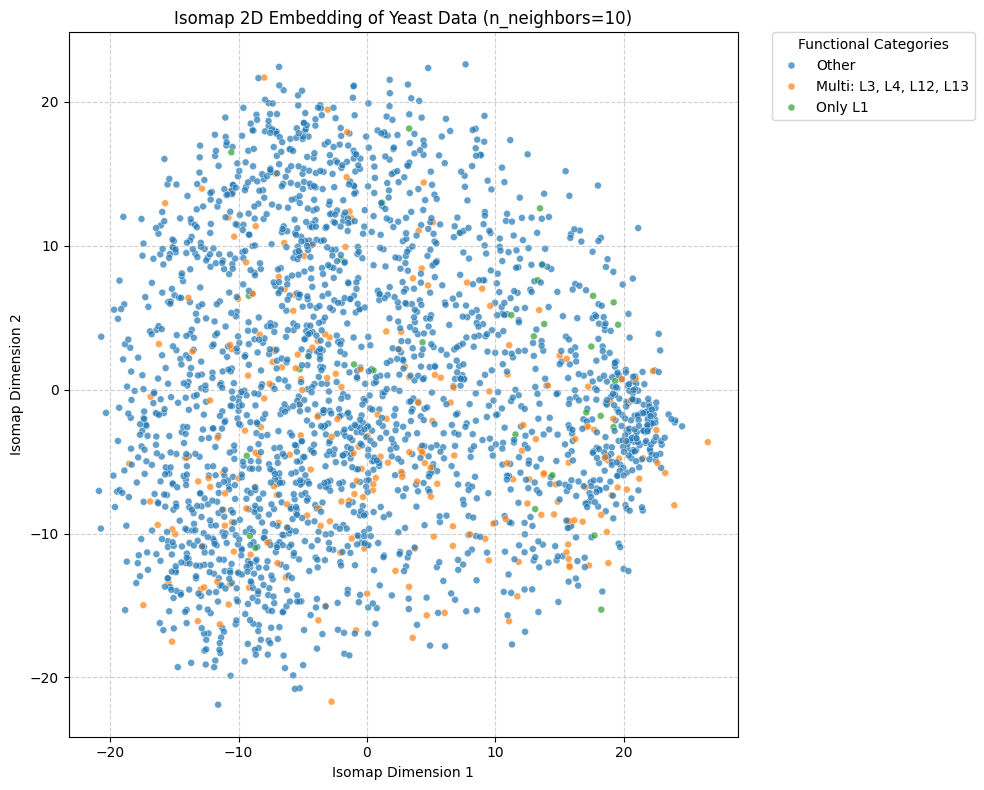

In [42]:
# 2. Visualization
print(f"\n--- 2. Visualization (Isomap with n_neighbors={n_neighbors}) ---")

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=isomap_2d[:, 0], y=isomap_2d[:, 1],
    hue=y_viz,
    palette=sns.color_palette("tab10", n_colors=len(np.unique(y_viz))),
    legend="full",
    alpha=0.7,
    s=25
)
plt.title(f'Isomap 2D Embedding of Yeast Data (n_neighbors={n_neighbors})')
plt.xlabel('Isomap Dimension 1')
plt.ylabel('Isomap Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Functional Categories")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

---
## **3. Comparison and Curvature**

#### **Comparison of Isomap vs. t-SNE Visualization (Global Structure)**

*   **Isomap Visualization**:
    *   Shows a more organized and continuous structure. There's a noticeable branch of data, especially towards the right, suggesting a prominent underlying global arrangement.
    *   The overall layout appears more coherent, indicating that distances between widely separated points are somewhat preserved.

*   **t-SNE Visualization**:
    *   Presents a more scattered and diffuse distribution, forming a large cloud with many smaller, intertwining local clusters.
    *   Distances between distinct clusters are not easily interpretable, as its strength lies in preserving local neighborhoods.

*   **Conclusion**: **Isomap is better at revealing the global structure** of the gene expression data. Its algorithm focuses on maintaining geodesic distances, which reflects the overall shape and topology of the data's manifold.

#### **Data Manifold Complexity and Classification Difficulty**

*   **Data Manifold**: This refers to the underlying, often curved or twisted, low-dimensional space where the high-dimensional data truly resides. Gene expression data, despite having many features, might intrinsically vary along only a few fundamental biological axes, implying it resides on a lower-dimensional manifold within the high-dimensional feature space.

*   **Does the Isomap plot suggest a highly curved or complex manifold?**
    Yes, the Isomap plot **does suggest a highly curved or complex manifold**.
    *   The data points are not arranged linearly or in simple, flat clusters. The elongated, bent, and somewhat dispersed "shape" of the main data mass, particularly the concentrations on the right, indicates non-linear relationships.
    *   This non-linear structure implies that the true distances between points are not straight lines in the original high-dimensional space but rather paths along a curved surface.

*   **How does the complexity of this manifold relate to the difficulty of classification?**
    The complex, curved manifold makes classification difficult because:
    1.  **Non-linear Separation**: Simple classifiers (like linear models) struggle to draw effective straight boundaries on a curved surface. They would require more complex, non-linear decision rules to separate the categories.
    2.  **Increased Overlap**: The manifold's complexity contributes to regions where different functional categories are thoroughly mixed. In these areas, samples from different classes have very similar gene expression profiles, making it hard for any classifier to distinguish them accurately. This leads to higher misclassification rates for simple models.